In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
!pip install plotly
import plotly.express as px

In [2]:
df = pd.read_csv('/kaggle/input/n86hd-abcd31-flights-data/df_n86hd_abcd31_data.csv')
df_train = pd.read_csv('/kaggle/input/n86hd-abcd31-flights-data/train_n86hd_abcd31.csv')
df_test = pd.read_csv('/kaggle/input/n86hd-abcd31-flights-data/test_n86hd_abcd31.csv')

In [3]:
df_train['geoaltitude'] = df_train['geoaltitude'].interpolate(method='linear')
df_test['geoaltitude'] = df_test['geoaltitude'].interpolate(method='linear')

In [4]:
# Split the N86HD data into df_train and df_test

# from sklearn.model_selection import train_test_split

# # Get the unique flight segments
# unique_segments = df['flight_segment'].unique()

# # Split the flight segments into two groups
# train_segments, test_segments = train_test_split(unique_segments, test_size=63, random_state=42)

# # Filter the dataset based on the split segments
# train_df = df[df['flight_segment'].isin(train_segments)]
# test_df = df[df['flight_segment'].isin(test_segments)]

# # Display the number of segments in each dataset to verify
# print(f"Number of unique flight segments in train_df: {train_df['flight_segment'].nunique()}")
# print(f"Number of unique flight segments in test_df: {test_df['flight_segment'].nunique()}")

# # Save the datasets if needed
# train_df.to_csv('/kaggle/working/train_n86hd_abcd31.csv', index=False)
# test_df.to_csv('/kaggle/working/test_n86hd_abcd31.csv', index=False)

df_train.describe()
#df_test.describe()

,lat,lon,geoaltitude,flight_segment
count,21707.000000,21707.000000,21707.000000,21707.000000
mean,33.796144,-84.452272,696.020671,102.360068
std,0.015822,0.028633,512.933677,60.615194
min,33.750183,-84.480000,327.660000,0.000000
25%,33.787537,-84.472476,441.960000,47.000000
50%,33.788452,-84.466209,472.440000,111.000000
75%,33.796188,-84.436602,723.900000,153.000000
max,33.849838,-84.380101,8900.160000,210.000000


In [5]:
# Normalization

from sklearn.preprocessing import MinMaxScaler
# Columns need normalized
columns_to_scale = ['lat', 'lon', 'geoaltitude']

scaler = MinMaxScaler()

# Normalize columns in df_train
df_train[columns_to_scale] = scaler.fit_transform(df_train[columns_to_scale])
print('df_train after normalization:')
print(df_train)

# Normalize columns in df_test according to the ratio of df_train
df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])
print('\ndf_test after normalization:')
print(df_test)

df_train after normalization:
                      time       lat       lon  geoaltitude  flight_segment
0      2016-12-01 18:02:12  0.458756  0.150642     0.022222               0
1      2016-12-01 18:02:14  0.458756  0.150642     0.021333               0
2      2016-12-01 18:02:16  0.458756  0.150642     0.021333               0
3      2016-12-01 18:02:18  0.428571  0.124692     0.018667               0
4      2016-12-01 18:02:20  0.419984  0.115702     0.016889               0
...                    ...       ...       ...          ...             ...
21702  2020-03-12 20:52:48  0.376206  0.088782     0.005333             210
21703  2020-03-12 20:52:50  0.376206  0.088782     0.005333             210
21704  2020-03-12 20:52:52  0.376206  0.088782     0.005333             210
21705  2020-03-12 20:52:54  0.376206  0.088782     0.005333             210
21706  2020-03-12 20:52:56  0.376206  0.088782     0.005333             210

[21707 rows x 5 columns]

df_test after normalization:
  

In [6]:
# Show the duration of each training flight segment

df_train['time'] = pd.to_datetime(df_train['time'])

# Group by 'flight_segment' and calculate the duration
train_flight_durations = df_train.groupby('flight_segment').agg(
    start_time=('time', 'min'),
    end_time=('time', 'max')
)

# Calculate the duration in seconds
train_flight_durations['duration (s)'] = (train_flight_durations['end_time'] - train_flight_durations['start_time']).dt.total_seconds()

# Display the DataFrame with calculated durations
print(train_flight_durations)

                        start_time            end_time  duration (s)
flight_segment                                                      
0              2016-12-01 18:02:12 2016-12-01 18:08:26         374.0
1              2016-12-02 21:27:10 2016-12-02 21:32:32         322.0
2              2017-01-12 17:35:40 2017-01-12 17:41:16         336.0
3              2017-01-20 20:43:50 2017-01-20 20:49:34         344.0
4              2017-02-23 21:56:44 2017-02-23 21:59:58         194.0
...                            ...                 ...           ...
202            2019-10-03 22:07:36 2019-10-03 22:13:44         368.0
203            2019-10-16 19:08:32 2019-10-16 19:09:34          62.0
205            2019-10-22 21:32:00 2019-10-22 21:38:10         370.0
207            2020-02-28 02:23:54 2020-02-28 02:32:14         500.0
210            2020-03-12 20:45:58 2020-03-12 20:52:56         418.0

[143 rows x 3 columns]


In [7]:
# Show the duration of each testing flight segment

df_test['time'] = pd.to_datetime(df_test['time'])

# Group by 'flight_segment' and calculate the duration
test_flight_durations = df_test.groupby('flight_segment').agg(
    start_time=('time', 'min'),
    end_time=('time', 'max')
)

# Calculate the duration in seconds
test_flight_durations['duration (s)'] = (test_flight_durations['end_time'] - test_flight_durations['start_time']).dt.total_seconds()

# Display the DataFrame with calculated durations
print(test_flight_durations)

                        start_time            end_time  duration (s)
flight_segment                                                      
5              2017-02-27 21:07:18 2017-02-27 21:08:40          82.0
9              2017-03-07 19:14:48 2017-03-07 19:21:42         414.0
15             2017-04-11 22:01:42 2017-04-11 22:08:48         426.0
16             2017-04-12 21:30:24 2017-04-12 21:37:36         432.0
18             2017-04-19 12:14:50 2017-04-19 12:21:24         394.0
...                            ...                 ...           ...
195            2019-08-23 00:48:42 2019-08-23 00:55:46         424.0
200            2019-09-12 11:38:38 2019-09-12 11:39:52          74.0
204            2019-10-16 23:59:48 2019-10-17 00:05:56         368.0
206            2019-10-23 21:00:54 2019-10-23 21:02:18          84.0
209            2020-03-12 12:20:56 2020-03-12 12:22:18          82.0

[61 rows x 3 columns]


In [8]:
# Extract details for 'flight_segment' 9
flight_segment_9 = test_flight_durations.loc[9]

# Display the details for 'flight_segment' 9
print(flight_segment_9)

start_time      2017-03-07 19:14:48
end_time        2017-03-07 19:21:42
duration (s)                  414.0
Name: 9, dtype: object


In [9]:
# Split df_train into X_train and y_train

# Ensure the data is sorted by flight segment and time
df_train = df_train.sort_values(by=['flight_segment', 'time'])

def create_sequences_for_segment(segment_df, input_steps, output_steps):
    segment_data = segment_df[['lat', 'lon', 'geoaltitude']].values
    X, y = [], []
    for i in range(len(segment_data) - input_steps - output_steps + 1):
        X.append(segment_data[i:i+input_steps])
        y.append(segment_data[i+input_steps:i+input_steps+output_steps])
    return X, y

# Initialize empty lists to hold all sequences
X_train_list, y_train_list = [], []

# Define the input and output steps
input_steps = 15  # 30 seconds / 2 seconds per step = 15 steps
output_steps = 5  # 10 seconds / 2 seconds per step = 5 steps

# Group the DataFrame by flight segment and create sequences for each segment
for flight_segment, segment_df in df_train.groupby('flight_segment'):
    X_segment, y_segment = create_sequences_for_segment(segment_df, input_steps, output_steps)
    X_train_list.extend(X_segment)
    y_train_list.extend(y_segment)

# Convert lists to numpy arrays
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)

# Print the shapes to confirm
print(f'X_train shape: {X_train.shape}')  # Should be (number of samples, 15, 3)
print(f'y_train shape: {y_train.shape}')  # Should be (number of samples, 5, 3)

# Example of the first input-output pair
print(f'First input: {X_train[0]}')
print(f'First output: {y_train[0]}')


X_train shape: (18990, 15, 3)
y_train shape: (18990, 5, 3)
First input: [[0.45875602 0.15064234 0.02222222]
 [0.45875602 0.15064234 0.02133333]
 [0.45875602 0.15064234 0.02133333]
 [0.42857143 0.12469169 0.01866667]
 [0.41998396 0.11570248 0.01688889]
 [0.41998396 0.11570248 0.016     ]
 [0.4036343  0.09450945 0.01422222]
 [0.40009187 0.08878161 0.01333333]
 [0.393661   0.0775597  0.01333333]
 [0.393661   0.0775597  0.01333333]
 [0.393661   0.0775597  0.01333333]
 [0.393661   0.0775597  0.01333333]
 [0.393661   0.0775597  0.01333333]
 [0.393661   0.0775597  0.01333333]
 [0.393661   0.0775597  0.01333333]]
First output: [[0.393661   0.0775597  0.01333333]
 [0.393661   0.0775597  0.01333333]
 [0.393661   0.0775597  0.01333333]
 [0.393661   0.0775597  0.01333333]
 [0.393661   0.0775597  0.01333333]]


In [10]:
# Create csv file for X_train and y_train

# # Reshape X_train and y_train to 2D arrays to save them to CSV files
# X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
# y_train_reshaped = y_train.reshape(y_train.shape[0], -1)

# # Create DataFrames
# X_train_df = pd.DataFrame(X_train_reshaped)
# y_train_df = pd.DataFrame(y_train_reshaped)

# # Save DataFrames to CSV files
# X_train_df.to_csv('/kaggle/working/n86hd_x_train.csv', index=False)
# y_train_df.to_csv('/kaggle/working/n86hd_y_train.csv', index=False)

In [11]:
# Split df_test into X_test and y_test

# Ensure the data is sorted by flight segment and time
df_test = df_test.sort_values(by=['flight_segment', 'time'])

def create_sequences_for_segment(segment_df, input_steps, output_steps):
    segment_data = segment_df[['lat', 'lon', 'geoaltitude']].values
    X, y = [], []
    for i in range(len(segment_data) - input_steps - output_steps + 1):
        X.append(segment_data[i:i+input_steps])
        y.append(segment_data[i+input_steps:i+input_steps+output_steps])
    return X, y

# Initialize empty lists to hold all sequences
X_test_list, y_test_list = [], []

# Define the input and output steps
input_steps = 15  # 30 seconds / 2 seconds per step = 15 steps
output_steps = 5  # 10 seconds / 2 seconds per step = 5 steps

# Group the DataFrame by flight segment and create sequences for each segment
for flight_segment, segment_df in df_test.groupby('flight_segment'):
    X_segment, y_segment = create_sequences_for_segment(segment_df, input_steps, output_steps)
    X_test_list.extend(X_segment)
    y_test_list.extend(y_segment)

# Convert lists to numpy arrays
X_test = np.array(X_test_list)
y_test = np.array(y_test_list)

# Print the shapes to confirm
print(f'X_test shape: {X_test.shape}')  # Should be (number of samples, 15, 3)
print(f'y_test shape: {y_test.shape}')  # Should be (number of samples, 5, 3)

# Example of the first input-output pair
print(f'First input: {X_test[0]}')
print(f'First output: {y_test[0]}')

X_test shape: (7966, 15, 3)
y_test shape: (7966, 5, 3)
First input: [[0.36953357 0.01260126 0.048     ]
 [0.3756063  0.03780378 0.04888889]
 [0.37988057 0.05736028 0.05155556]
 [0.3854161  0.08133541 0.05244444]
 [0.39055457 0.10424679 0.05511111]
 [0.39475876 0.12200311 0.05688889]
 [0.4008315  0.15006955 0.05777778]
 [0.4064371  0.17355372 0.05866667]
 [0.41157556 0.19703789 0.06044444]
 [0.41718116 0.22052205 0.06044444]
 [0.42076252 0.2374718  0.06133333]
 [0.42512243 0.25488913 0.06133333]
 [0.43086817 0.28011502 0.06311111]
 [0.43592099 0.30424211 0.064     ]
 [0.44193923 0.33106947 0.06488889]]
First output: [[0.44754483 0.35512642 0.064     ]
 [0.45245751 0.37774557 0.064     ]
 [0.45751034 0.40131156 0.064     ]
 [0.46296022 0.42787006 0.064     ]
 [0.46899403 0.4540545  0.064     ]]


In [12]:
# Create csv file for X_test and y_test

# # Reshape X_train and y_train to 2D arrays to save them to CSV files
# X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
# y_test_reshaped = y_test.reshape(y_test.shape[0], -1)

# # Create DataFrames
# X_test_df = pd.DataFrame(X_test_reshaped)
# y_test_df = pd.DataFrame(y_test_reshaped)

# # Save DataFrames to CSV files
# X_test_df.to_csv('/kaggle/working/n86hd_x_test.csv', index=False)
# y_test_df.to_csv('/kaggle/working/n86hd_y_test.csv', index=False)

In [13]:
# Show information of flight segment 9 of N86HD

segment_9_data = df[df['flight_segment'] == 9]
segment_9_data

,time,lat,lon,geoaltitude,flight_segment
1129,2017-03-07 19:14:48,33.799393,-84.393890,807.72,9
1130,2017-03-07 19:14:50,33.799159,-84.395657,800.10,9
1131,2017-03-07 19:14:52,33.798935,-84.396861,800.10,9
1132,2017-03-07 19:14:54,33.798706,-84.398374,784.86,9
1133,2017-03-07 19:14:56,33.798414,-84.400520,784.86,9
...,...,...,...,...,...
1332,2017-03-07 19:21:34,33.786869,-84.476109,419.10,9
1333,2017-03-07 19:21:36,33.786869,-84.476109,419.10,9
1334,2017-03-07 19:21:38,33.786869,-84.476109,419.10,9
1335,2017-03-07 19:21:40,33.786869,-84.476109,419.10,9


In [14]:
# Plot flight segment 9 of N86HD

latitudes = segment_9_data['lat']
longitudes = segment_9_data['lon']

# Create DataFrame from the data
data = {'lat': latitudes, 'lon': longitudes}
df_9 = pd.DataFrame(data)

# Draw flight trajectory using Plotly
fig = px.line_mapbox(df_9, lat="lat", lon="lon", zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(title="Flight N86HD - segment 9 Trajectory")
fig.show()

In [15]:
print(f'X_train: {np.isnan(X_train).sum()} NaNs, {np.isinf(X_train).sum()} infs')
print(f'y_train: {np.isnan(y_train).sum()} NaNs, {np.isinf(y_train).sum()} infs')
print(f'X_test: {np.isnan(X_test).sum()} NaNs, {np.isinf(X_test).sum()} infs')
print(f'y_test: {np.isnan(y_test).sum()} NaNs, {np.isinf(y_test).sum()} infs')

X_train: 0 NaNs, 0 infs
y_train: 0 NaNs, 0 infs
X_test: 0 NaNs, 0 infs
y_test: 0 NaNs, 0 infs


In [16]:
# Build Seq2Seq model with LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed

model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(RepeatVector(y_train.shape[1]))  # Repeat vector to match output time steps
model.add(LSTM(units=50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(units=y_train.shape[2])))  # Ensure the output shape matches y_train

model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f'LSTM Test loss: {loss}')

2024-07-08 04:35:36.651821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 04:35:36.651891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 04:35:36.653704: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



475/475 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0263 - val_loss: 4.5260e-04
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 5.2898e-04 - val_loss: 3.2062e-04
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 3.2914e-04 - val_loss: 1.3850e-04
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.5247e-04 - val_loss: 1.8031e-04
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.2714e-04 - val_loss: 1.9321e-04
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2.0309e-04 - val_loss: 1.0317e-04
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.1793e-04 - val_loss: 1.8059e-04
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 1.9899e-04 - val_loss: 1.0895e-04
Epoch 9/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.7012e-04 - val_loss: 9.0139e-05
Epoch 10/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 1.6153e-04 - val_loss: 1.1047e-04
Epoch 11/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.

In [17]:
from sklearn.metrics import mean_squared_error

# Predict on testing data
y_lstm_pred = model.predict(X_test)

# Calculate RMSE
lstm_rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_lstm_pred.flatten()))
print(f'LSTM RMSE: {lstm_rmse}')

# Plot the comparison between the predicted and the actual outcome for a random sample
sample_idx = 23

249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
LSTM RMSE: 0.021709522620532568


In [18]:
# Print out the sample's input, predicted and actual outcomes
print("Input (X_test) for Sample {}:".format(sample_idx))
print(X_test[sample_idx])
print("\nActual Output (y_test) for Sample {}:".format(sample_idx))
print(y_test[sample_idx])
print("\nPredicted Output using LSTM (y_pred) for Sample {}:".format(sample_idx))
print(y_lstm_pred[sample_idx])

Input (X_test) for Sample 23:
[[0.49379881 0.86197061 0.056     ]
 [0.49145535 0.84428443 0.05511111]
 [0.48920533 0.83223257 0.05511111]
 [0.48690859 0.81708301 0.05333333]
 [0.48398122 0.79559774 0.05333333]
 [0.48164555 0.78299648 0.05244444]
 [0.47930989 0.76695851 0.05155556]
 [0.47650709 0.75034776 0.05066667]
 [0.47463856 0.73717372 0.04977778]
 [0.47136862 0.71827183 0.04977778]
 [0.46856582 0.70223386 0.04977778]
 [0.46623016 0.68619589 0.04711111]
 [0.46389449 0.67015792 0.04533333]
 [0.46118512 0.65548763 0.04533333]
 [0.45888838 0.64033806 0.04355556]]

Actual Output (y_test) for Sample 23:
[[0.45642036 0.62318959 0.04266667]
 [0.45455182 0.61116112 0.04177778]
 [0.45221616 0.59626872 0.04088889]
 [0.44988049 0.57908518 0.04      ]
 [0.44786403 0.56571242 0.03822222]]

Predicted Output using LSTM (y_pred) for Sample 23:
[[0.45841536 0.62902546 0.04492723]
 [0.46162573 0.618389   0.04526353]
 [0.46104634 0.6025647  0.04399559]
 [0.45922545 0.5865935  0.04305449]
 [0.45739958

In [19]:
# Define min and max values for each feature
lat_min, lat_max = 33.750183, 33.849838
lon_min, lon_max = -84.480000, -84.380101
geoaltitude_min, geoaltitude_max = 327.660000, 8900.160000

# Function to de-normalize data
def denormalize(data, min_val, max_val):
    return data * (max_val - min_val) + min_val

# Example de-normalization for a single array
def denormalize_array(array):
    array[:, 0] = denormalize(array[:, 0], lat_min, lat_max)  # De-normalize lat
    array[:, 1] = denormalize(array[:, 1], lon_min, lon_max)  # De-normalize lon
    array[:, 2] = denormalize(array[:, 2], geoaltitude_min, geoaltitude_max)  # De-normalize geoaltitude
    return array

# De-normalize the selected input, actual output, and predicted output
X_test_denorm = denormalize_array(X_test[sample_idx].copy())
y_test_denorm = denormalize_array(y_test[sample_idx].copy())
y_lstm_pred_denorm = denormalize_array(y_lstm_pred[sample_idx].copy())

# Print the corresponding input, predicted, and actual output
print(f'Input sequence (sample {sample_idx}):')
print(X_test_denorm)
print(f'Actual output (sample {sample_idx}):')
print(y_test_denorm)
print(f'Predicted output using LSTM (sample {sample_idx}):')
print(y_lstm_pred_denorm)

Input sequence (sample 23):
[[ 33.79939252 -84.39389    807.72      ]
 [ 33.79915898 -84.39565683 800.1       ]
 [ 33.79893476 -84.3968608  800.1       ]
 [ 33.79870588 -84.39837422 784.86      ]
 [ 33.79841415 -84.40052058 784.86      ]
 [ 33.79818139 -84.40177943 777.24      ]
 [ 33.79794863 -84.40338161 769.62      ]
 [ 33.79766931 -84.40504101 762.        ]
 [ 33.79748311 -84.40635708 754.38      ]
 [ 33.79715724 -84.40824536 754.38      ]
 [ 33.79687793 -84.40984754 754.38      ]
 [ 33.79664517 -84.41144972 731.52      ]
 [ 33.79641241 -84.41305189 716.28      ]
 [ 33.7961424  -84.41451744 716.28      ]
 [ 33.79591352 -84.41603087 701.04      ]]
Actual output (sample 23):
[[ 33.79566757 -84.41774398 693.42      ]
 [ 33.79548136 -84.41894562 685.8       ]
 [ 33.7952486  -84.42043335 678.18      ]
 [ 33.79501584 -84.42214997 670.56      ]
 [ 33.79481489 -84.4234859  655.32      ]]
Predicted output using LSTM (sample 23):
[[ 33.795868 -84.41717  712.7987  ]
 [ 33.796185 -84.41823  71

In [20]:
# Build Seq2Seq model with GRU

from tensorflow.keras.layers import GRU

gru_model = Sequential()
gru_model.add(GRU(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(RepeatVector(y_train.shape[1]))  # Repeat vector to match output time steps
gru_model.add(GRU(units=50, activation='relu', return_sequences=True))
gru_model.add(TimeDistributed(Dense(units=y_train.shape[2])))  # Ensure the output shape matches y_train

gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
gru_history = gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate model
gru_loss = gru_model.evaluate(X_test, y_test)
print(f'GRU Test loss: {gru_loss}')

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



475/475 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0213 - val_loss: 3.2193e-04
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 3.5338e-04 - val_loss: 1.7948e-04
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2.7403e-04 - val_loss: 1.5397e-04
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2.2580e-04 - val_loss: 1.0027e-04
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2.4328e-04 - val_loss: 9.5648e-05
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 2.0421e-04 - val_loss: 1.1723e-04
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2.2274e-04 - val_loss: 9.3862e-05
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 1.7967e-04 - val_loss: 1.0622e-04
Epoch 9/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 1.7462e-04 - val_loss: 9.5855e-05
Epoch 10/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 1.4823e-04 - val_loss: 1.1957e-04
Epoch 11/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 1

In [23]:
# Predict on testing data
y_gru_pred = gru_model.predict(X_test)
# De-normalize the selected input, actual output, and predicted output
X_test_denorm = denormalize_array(X_test[sample_idx].copy())
y_test_denorm = denormalize_array(y_test[sample_idx].copy())
y_gru_pred_denorm = denormalize_array(y_gru_pred[sample_idx].copy())

# Print the corresponding input, predicted, and actual output
print(f'Input sequence (sample {sample_idx}):')
print(X_test_denorm)
print(f'Actual output (sample {sample_idx}):')
print(y_test_denorm)
print(f'Predicted output using GRU (sample {sample_idx}):')
print(y_gru_pred_denorm)

249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Input sequence (sample 23):
[[ 33.79939252 -84.39389    807.72      ]
 [ 33.79915898 -84.39565683 800.1       ]
 [ 33.79893476 -84.3968608  800.1       ]
 [ 33.79870588 -84.39837422 784.86      ]
 [ 33.79841415 -84.40052058 784.86      ]
 [ 33.79818139 -84.40177943 777.24      ]
 [ 33.79794863 -84.40338161 769.62      ]
 [ 33.79766931 -84.40504101 762.        ]
 [ 33.79748311 -84.40635708 754.38      ]
 [ 33.79715724 -84.40824536 754.38      ]
 [ 33.79687793 -84.40984754 754.38      ]
 [ 33.79664517 -84.41144972 731.52      ]
 [ 33.79641241 -84.41305189 716.28      ]
 [ 33.7961424  -84.41451744 716.28      ]
 [ 33.79591352 -84.41603087 701.04      ]]
Actual output (sample 23):
[[ 33.79566757 -84.41774398 693.42      ]
 [ 33.79548136 -84.41894562 685.8       ]
 [ 33.7952486  -84.42043335 678.18      ]
 [ 33.79501584 -84.42214997 670.56      ]
 [ 33.79481489 -84.4234859  655.32      ]]
Predicted output using GRU (sample 23):
[[ 33.79485  -84.41774

GRU RMSE: 0.027275383274171745


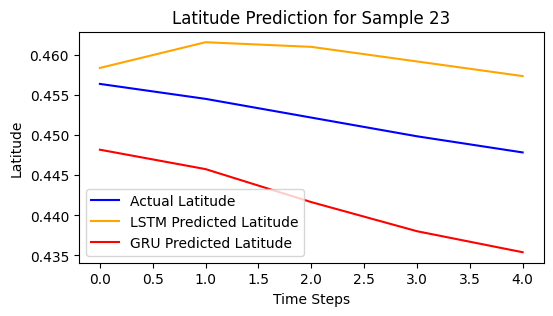

In [24]:
# Calculate RMSE
gru_rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_gru_pred.flatten()))
print(f'GRU RMSE: {gru_rmse}')

actual_lat = y_test[sample_idx][:, 0]
lstm_predicted_lat = y_lstm_pred[sample_idx][:, 0]
gru_predicted_lat = y_gru_pred[sample_idx][:, 0]

actual_lon = y_test[sample_idx][:, 1]
lstm_predicted_lon = y_lstm_pred[sample_idx][:, 1]
gru_predicted_lon = y_gru_pred[sample_idx][:, 1]

actual_geoaltitude = y_test[sample_idx][:, 2]
lstm_predicted_geoaltitude = y_lstm_pred[sample_idx][:, 2]
gru_predicted_geoaltitude = y_gru_pred[sample_idx][:, 2]

# Plot the 'lat' values
plt.figure(figsize=(6, 3))
plt.plot(actual_lat, color='blue', label='Actual Latitude')
plt.plot(lstm_predicted_lat, color='orange', label='LSTM Predicted Latitude')
plt.plot(gru_predicted_lat, color='red', label='GRU Predicted Latitude')
plt.title('Latitude Prediction for Sample {}'.format(sample_idx))
plt.xlabel('Time Steps')
plt.ylabel('Latitude')
plt.legend()
plt.show()


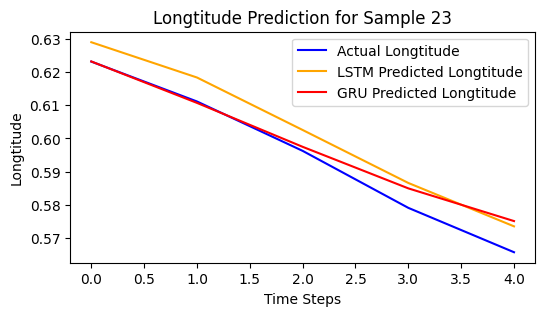

In [25]:
# Plot the 'lon' values
plt.figure(figsize=(6, 3))
plt.plot(actual_lon, color='blue', label='Actual Longtitude')
plt.plot(lstm_predicted_lon, color='orange', label='LSTM Predicted Longtitude')
plt.plot(gru_predicted_lon, color='red', label='GRU Predicted Longtitude')
plt.title('Longtitude Prediction for Sample {}'.format(sample_idx))
plt.xlabel('Time Steps')
plt.ylabel('Longtitude')
plt.legend()
plt.show()

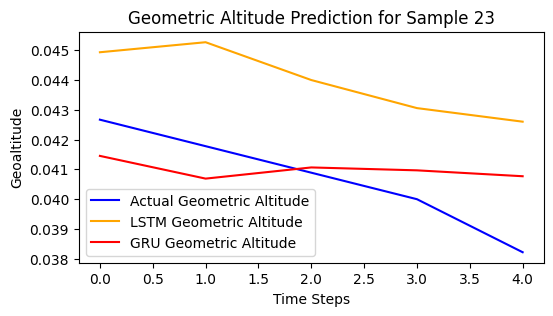

In [26]:
# Plot the 'geoaltitude' values
plt.figure(figsize=(6, 3))
plt.plot(actual_geoaltitude, color='blue', label='Actual Geometric Altitude')
plt.plot(lstm_predicted_geoaltitude, color='orange', label='LSTM Geometric Altitude')
plt.plot(gru_predicted_geoaltitude, color='red', label='GRU Geometric Altitude')
plt.title('Geometric Altitude Prediction for Sample {}'.format(sample_idx))
plt.xlabel('Time Steps')
plt.ylabel('Geoaltitude')
plt.legend()
plt.show()

In [27]:
# Create DataFrames
input_df = pd.DataFrame(X_test_denorm, columns=['lat', 'lon', 'geoaltitude'])
actual_df = pd.DataFrame(y_test_denorm, columns=['lat', 'lon', 'geoaltitude'])
lstm_predicted_df = pd.DataFrame(y_lstm_pred_denorm, columns=['lat', 'lon', 'geoaltitude'])
gru_predicted_df = pd.DataFrame(y_gru_pred_denorm, columns=['lat', 'lon', 'geoaltitude'])

# Plot using Plotly
fig = px.line_mapbox(input_df, lat="lat", lon="lon", zoom=3, height=400)
fig.add_scattermapbox(lat=actual_df['lat'], lon=actual_df['lon'], mode='lines', name='Actual', marker=dict(color='blue'))
fig.add_scattermapbox(lat=lstm_predicted_df['lat'], lon=lstm_predicted_df['lon'], mode='lines', name='Predicted using LSTM', marker=dict(color='red'))
fig.add_scattermapbox(lat=gru_predicted_df['lat'], lon=gru_predicted_df['lon'], mode='lines', name='Predicted using GRU', marker=dict(color='green'))

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(title='Sample {} Prediction'.format(sample_idx))
fig.show()

In [28]:
predicted_segment_9 = X_test[sample_idx].copy()
predicted_segment_9

iterations = 25
i = 0

# Iterate to predict the entire flight
while i < (iterations * 5):
    print(i)
    # Prepare the new input sequence for prediction
    new_input = predicted_segment_9[i:i+15]

    # Reshape new_input to match the model's expected input shape (1, 15, 3)
    new_input_reshaped = new_input.reshape(1, 15, 3)

    # Predict the next 5 steps
    new_output = model.predict(new_input_reshaped)

    # Append the predicted output to the trajectory
    predicted_segment_9 = np.concatenate((predicted_segment_9, new_output.reshape(5, 3)))
    
    # Increment by 5 steps to continue the prediction
    i += 5

# De-normalize the predicted trajectory
predicted_segment_9_denorm = denormalize_array(predicted_segment_9)

# Create DataFrame for plotting
predicted_segment_9_df = pd.DataFrame(predicted_segment_9_denorm, columns=['lat', 'lon', 'geoaltitude'])
print(predicted_segment_9_df)

# Plot using Plotly
fig = px.line_mapbox(df_9, lat="lat", lon="lon", zoom=3, height=400)
fig.add_scattermapbox(lat=predicted_segment_9_df['lat'], lon=predicted_segment_9_df['lon'], mode='lines', name='Predicted using LSTM', marker=dict(color='red'))
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(title="Predicted Flight segment 9 using LSTM")
fig.show()

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
110
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
120
1/1 ━━━━━━

In [29]:
predicted_segment_9 = X_test[sample_idx].copy()
predicted_segment_9

iterations = 25
i = 0

# Iterate to predict the entire flight
while i < (iterations * 5):
    print(i)
    # Prepare the new input sequence for prediction
    new_input = predicted_segment_9[i:i+15]

    # Reshape new_input to match the model's expected input shape (1, 15, 3)
    new_input_reshaped = new_input.reshape(1, 15, 3)

    # Predict the next 5 steps
    new_output = gru_model.predict(new_input_reshaped)

    # Append the predicted output to the trajectory
    predicted_segment_9 = np.concatenate((predicted_segment_9, new_output.reshape(5, 3)))
    
    # Increment by 5 steps to continue the prediction
    i += 5

# De-normalize the predicted trajectory
predicted_segment_9_denorm = denormalize_array(predicted_segment_9)

# Create DataFrame for plotting
predicted_segment_9_df = pd.DataFrame(predicted_segment_9_denorm, columns=['lat', 'lon', 'geoaltitude'])
print(predicted_segment_9_df)

# Plot using Plotly
fig = px.line_mapbox(df_9, lat="lat", lon="lon", zoom=3, height=400)
fig.add_scattermapbox(lat=predicted_segment_9_df['lat'], lon=predicted_segment_9_df['lon'], mode='lines', name='Predicted using GRU', marker=dict(color='red'))
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(title="Predicted Flight segment 9 using GRU")
fig.show()

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
110
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
120
1/1 ━━━━━━